In [16]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
# parameters
RANDOM_SEED = 42
lr = 0.001
bs = 32
n_epochs = 15

img_size = 32
n_classes = 10

100%|██████████| 9912422/9912422 [00:00<00:00, 76023879.67it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21402066.05it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67445790.88it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14410384.85it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



Text(0.5, 0.98, 'preview')

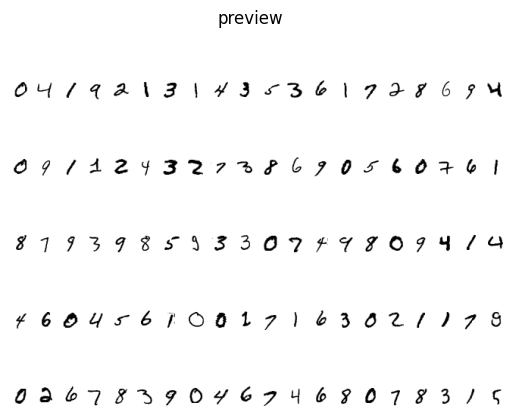

In [4]:
transforms = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

train_dataset = datasets.MNIST(root = 'mnist_data',
                               train= True,
                               transform= transforms,
                               download=True)
valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform= transforms)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size = bs,
                          shuffle = True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size = bs,
                          shuffle=False)

ROW_IMG = 20
N_ROWS= 5
fig = plt.figure()
for i in range(1, ROW_IMG*N_ROWS + 1):
  plt.subplot(N_ROWS, ROW_IMG, i)
  plt.axis('off')
  plt.imshow(train_dataset.data[i], cmap='gray_r')
fig.suptitle('preview')

In [5]:
def get_accuracy(model, data_loader, device):
  correct_pred = 0
  n = 0
  with torch.no_grad():
    model.eval()
    for X,y_true in data_loader:
      X=X.to(device)
      y_true = y_true.to(device)
      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob,1)
      n+=y_true.size(0)
      correct_pred += (predicted_labels==y_true).sum()
  return correct_pred.float() / n

In [6]:
def plot_losses(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''

    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()

In [8]:
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for X,y_true in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [7]:
def validate(valids_loader, model, criterion, optimizer, device):
  model.eval()
  running_loss = 0

  for X,y_true in valid_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss

In [25]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  for epoch in range(0,epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)
    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, optimizer, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == (print_every-1):
      train_acc = get_accuracy(model, train_loader, device)
      valid_acc = get_accuracy(model, valid_loader, device)

    print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

  plot_losses(train_losses, valid_losses)

  return model, optimizer, (train_losses, valid_losses)

In [26]:
class LeNet5(nn.Module):
  def __init__(self, n_classes):
    super(LeNet5, self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=5, stride = 1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size=5, stride = 1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size=5, stride = 1),
        nn.Tanh(),
        )
    self.classifier = nn.Sequential(
        nn.Linear(in_features = 120, out_features = 84),
        nn.Tanh(),
        nn.Linear(in_features = 84, out_features = n_classes)
    )
  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probs = F.softmax(logits, dim= 1)
    return logits, probs

In [27]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

05:27:24 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
05:28:25 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
05:29:26 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
05:30:27 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
05:31:28 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.25	Valid accuracy: 98.76
05:32:28 --- Epoch: 5	Train loss: 0.0298	Valid loss: 0.0433	Train accuracy: 99.36	Valid accuracy: 98.67
05:33:29 --- Epoch: 6	Train loss: 0.0245	Valid loss: 0.0417	Train accuracy: 99.48	Valid accuracy: 98.75
05:34:30 --- Epoch: 7	Train loss: 0.0221	Valid loss: 0.0469	Train accuracy: 99.45	Valid accuracy: 98.73
05:35:31 --- Epoch: 8	Train loss: 0.0188	Valid loss: 0.0462	Train accuracy: 99.45	Valid accuracy: 98.66
05:36:31 --- Epoch: 9	Train loss: 0.0169	Valid loss: 0.0525	Trai

<ipython-input-6-b656a67bb3aa>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


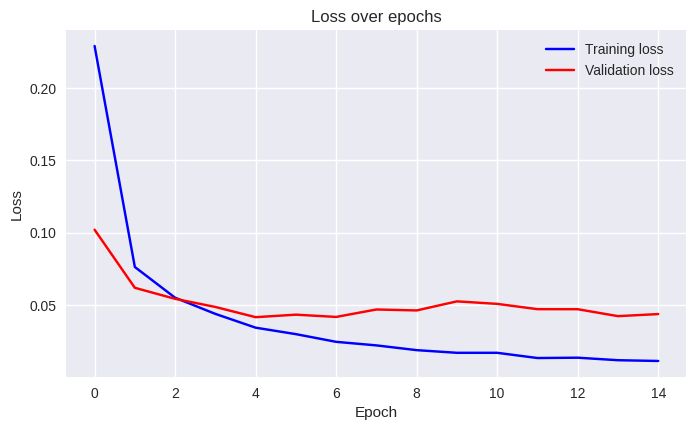

In [28]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader,
                                    valid_loader, n_epochs, device)